# Real estate market research

Project Description

We have at our disposal the data of the Real Estate service - an archive of ads for the sale of apartments in St. Petersburg and neighboring settlements for several years. Our task is to conduct an exploratory analysis of the data, which will help to establish the parameters that affect the price of objects. This will allow to build an automated system: it will track anomalies and fraudulent activity.
Two types of data are available for each apartment for sale. The first ones are entered by the user, the second ones are obtained automatically on the basis of cartographic data. For example, the distance to the center, airport and other objects - this data is automatically obtained from geoservices. The number of parks and reservoirs is also filled without user participation.

## 1. Lets look at the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('real_estate_data.csv', sep = '\t')

In [3]:
data.info()
print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

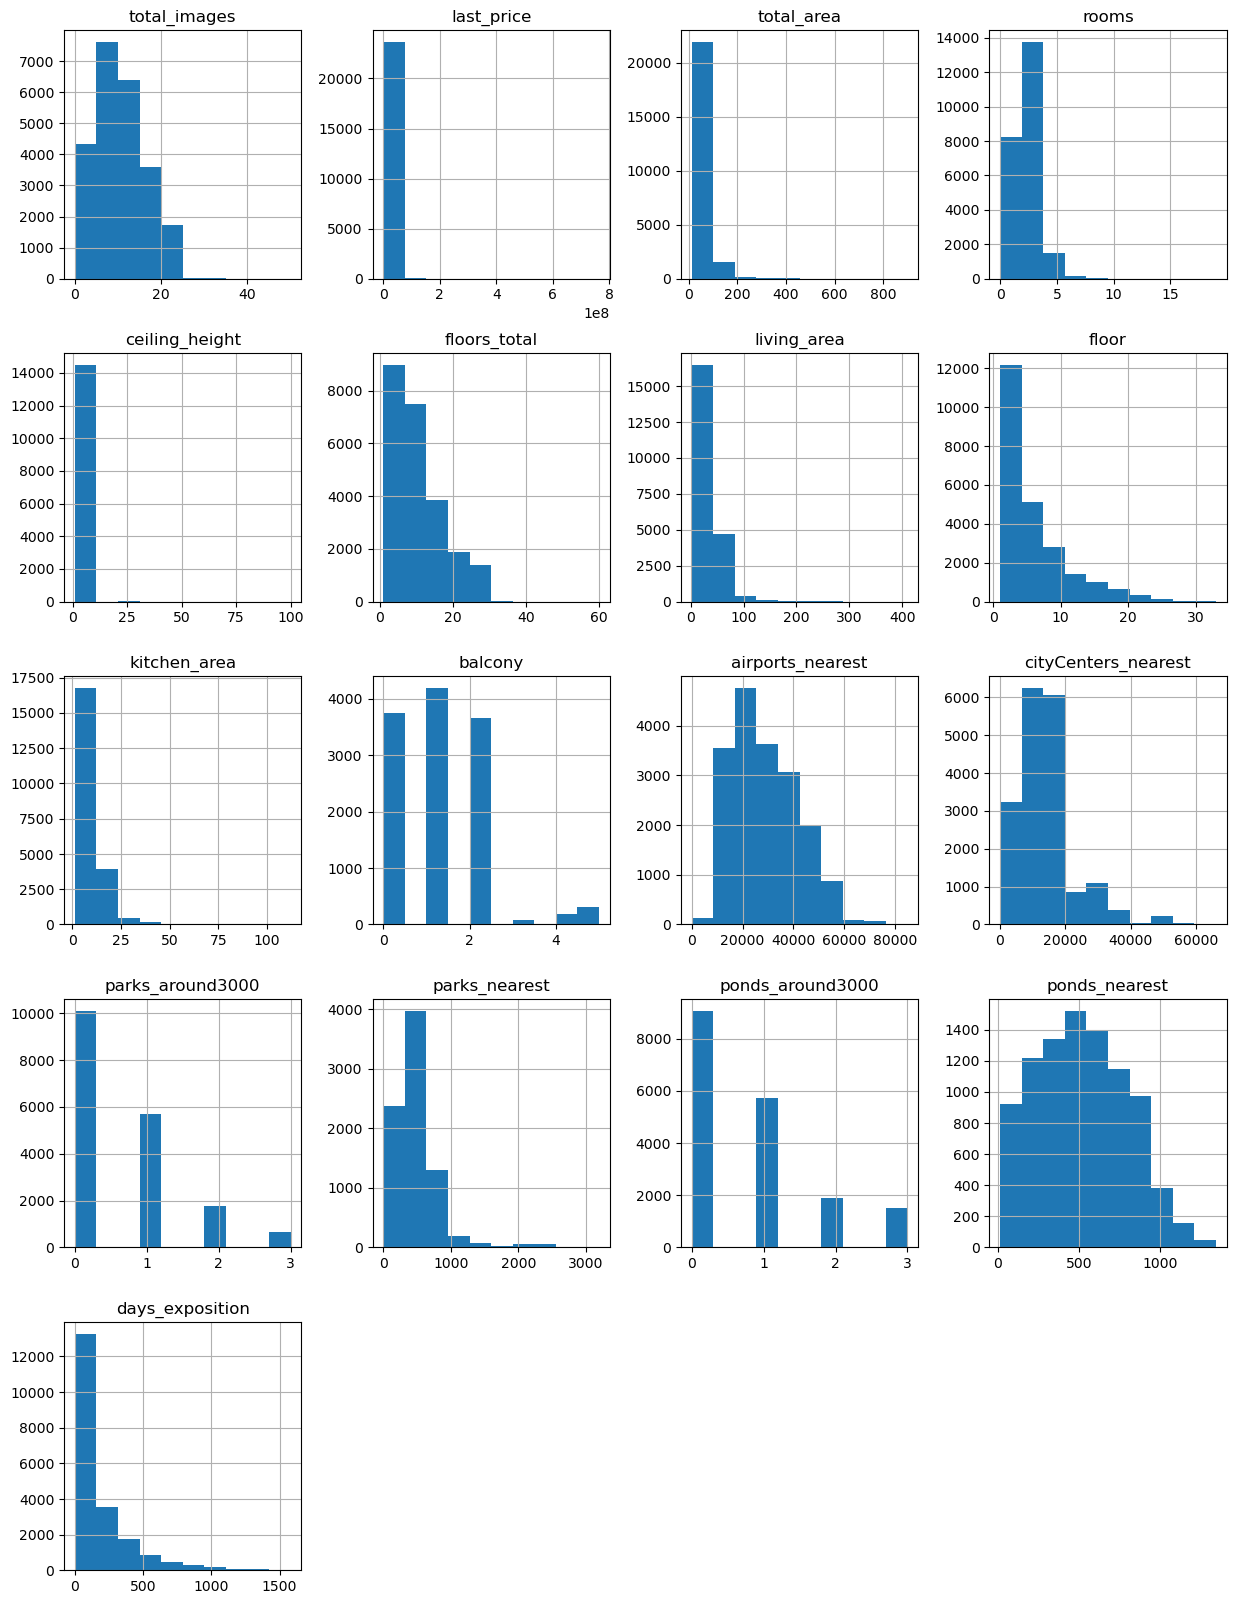

In [4]:
data.hist(figsize=(15, 20));

## 2. Data preprocessing

In [5]:
# Determining the presence of gaps in columns:

data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [6]:
# Getting rid of gaps in 'ceiling_height':

for value in data['floor'].unique():
    data.loc[(data['floor'] == value) & (data['ceiling_height'].isna()), 'ceiling_height'] = \
    data.loc[(data['floor'] == value), 'ceiling_height'].median()

In [7]:
# There are only 4 lines left with the value NaN, let's delete them. Too little to affect the results.

data = data[data['ceiling_height'].notna()]

In [8]:
# Getting rid of gaps in 'living_area':

data['living_area'].fillna(data['living_area'].median(), inplace=True)

In [9]:
# Let's remove a few lines with gaps:

data = data.dropna(subset=['floors_total','kitchen_area','locality_name']).reset_index(drop=True)

In [10]:
# Getting rid of gaps in 'cityCenters_nearest':

data['cityCenters_nearest'].fillna(data['cityCenters_nearest'].median(), inplace=True)

In [11]:
# Getting rid of gaps in 'kitchen_area':

for value in data['living_area'].unique():
    data.loc[(data['living_area'] == value) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[(data['living_area'] == value), 'kitchen_area'].median();

In [12]:
# Getting rid of gaps in 'balcony':

data['balcony'] = data['balcony'].fillna(0)

In [13]:
# Check

data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            18767
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         4816
cityCenters_nearest         0
parks_around3000         4794
parks_nearest           13975
ponds_around3000         4794
ponds_nearest           13118
days_exposition          2972
dtype: int64

There are various possible reasons for gaps in data. In the case of the data filled in by apartment owners, I believe that there is poor quality information in the advertisements. As for the cartographic data, most likely there is an error in calculating distances to various objects. The address may be specified incorrectly or insufficiently, resulting in the distance not being calculated.

In [14]:
# Changing data types in columns:

data['floors_total'] = data['floors_total'].astype(int)
data['balcony'] = data['balcony'].astype(int)
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
print(data.dtypes)

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int32
living_area                    float64
floor                            int64
is_apartment                    object
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int32
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object


In [15]:
# Getting rid of erroneously large values:

data = data[(data['ceiling_height'] <= 10)]

In [16]:
# Getting rid of implicit duplicates:

data['locality_name'] = data['locality_name'].str.replace('посёлок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', 'поселок')

In [17]:
# Check

data.duplicated().sum()

0

In [18]:
# let's add the required columns:

data['day_of_week']=data['first_day_exposition'].dt.dayofweek
data['exposition_month']=data['first_day_exposition'].dt.month
data['exposition_year']=data['first_day_exposition'].dt.year

In [19]:
# Price of m2:

data['price_m2'] = data['last_price'] / data['total_area']

In [20]:
# How far from the city center:

data['city_center_km'] = (data['cityCenters_nearest'] / 1000).round()

In [21]:
# Add categories: firts floor / last floor / Other:

def categorize_floors (floor):
    try:
        if floor['floor'] == floor['floors_total']:
            return 'последний'
        elif floor['floor'] == 1:
            return 'первый'
        else:
            return 'другой'
    except:
        pass
    
data['floor_type'] = data.apply(categorize_floors, axis = 1)

In [22]:
# Let's check that all new columns here:

print(data.head(5))

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0           2019-03-07      3   
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
3             2  10000000.0       100.0           2018-06-19      2   
4            10   2890000.0        30.4           2018-09-10      1   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70            16         51.0      8          NaN  ...   
1            2.60            11         18.6      1          NaN  ...   
2            2.65             5         34.3      4          NaN  ...   
3            3.03            14         32.0     13          NaN  ...   
4            2.60            12         14.4      5          NaN  ...   

   parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
0          482.0               2.0          755.0              N

## 4. Data exploration

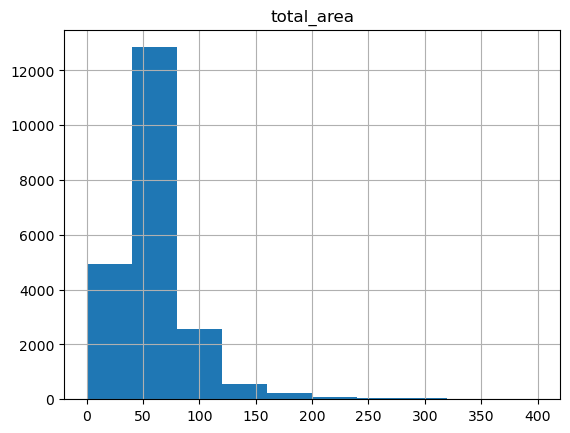

In [23]:
data.hist(column = 'total_area', range = (0, 400));

Most of the apartments have an area of up to 100 m2

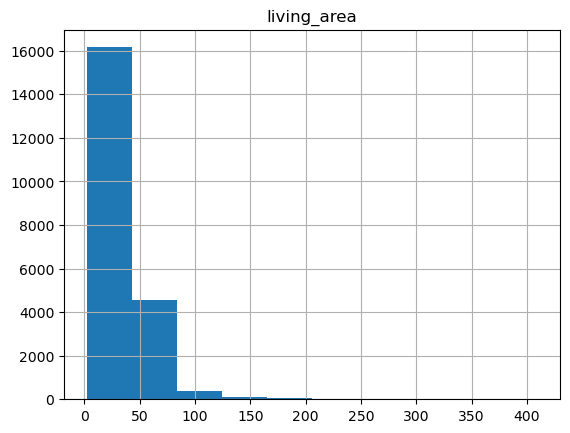

In [24]:
data.hist(column = 'living_area');

Living area of most apartments up to 40 m2

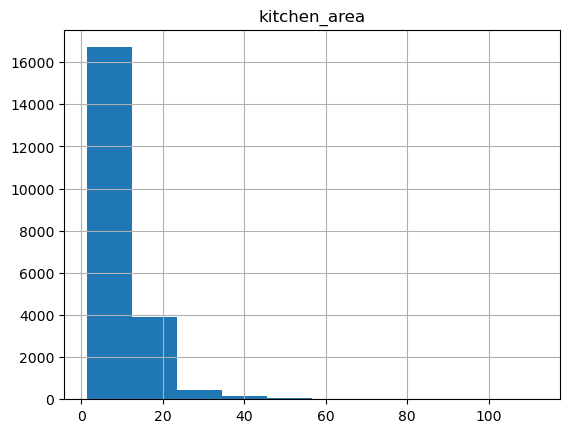

In [25]:
data.hist(column = 'kitchen_area');

Kitchen area in most apartments up to 10 m2

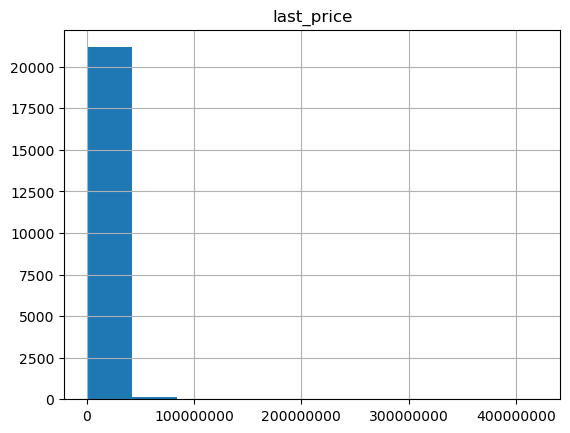

In [26]:
data.hist(column = 'last_price')
plt.ticklabel_format(axis = 'x', style = 'plain');

The price of most apartments is up to 40 million

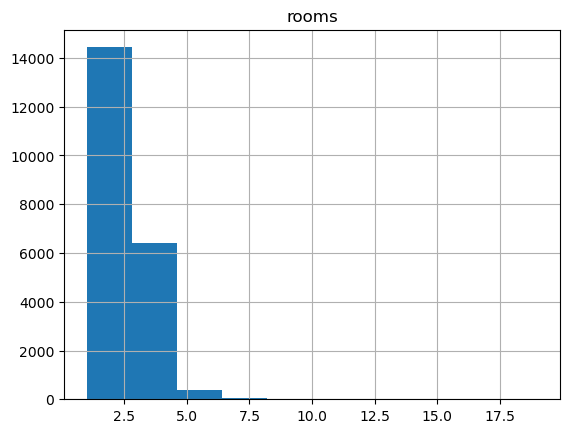

In [27]:
data.hist(column = 'rooms');

Approximately 2/3 of the apartments are two-room and 1/3 are three- and four-room

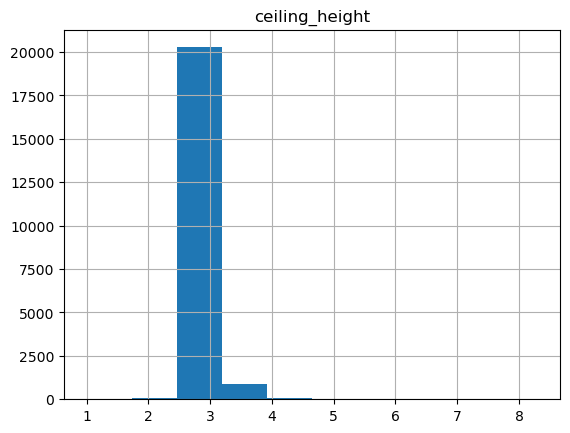

In [28]:
data.hist(column = 'ceiling_height');

Высота потолков в основной массе составляет от 2,5 до 3 метров

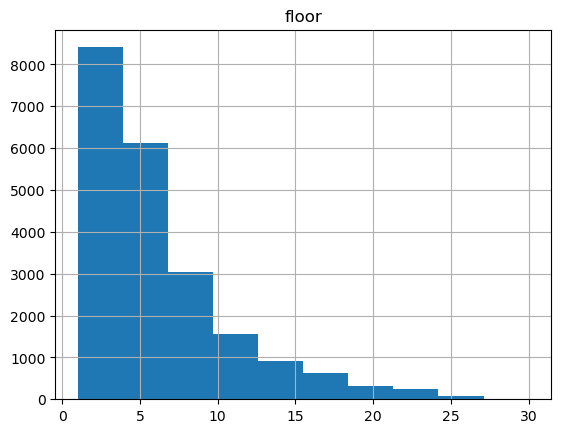

In [29]:
data.hist(column = 'floor');

There are few apartments on high floors on the market. This is due to the general height of buildings in the region

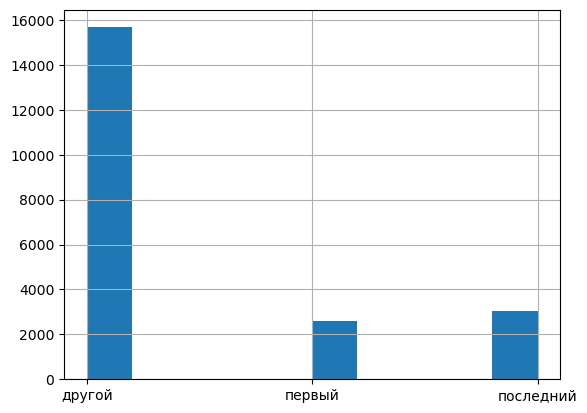

In [30]:
data['floor_type'].hist();

Approximately equal number of apartments on the first and last floors

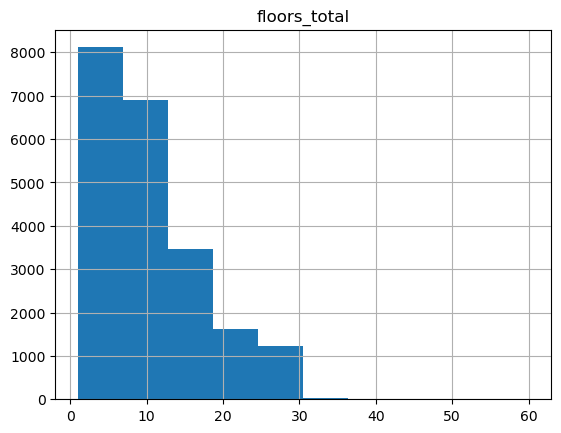

In [31]:
data.hist(column = 'floors_total');

The histogram confirms the hypothesis described above about the number of floors of buildings in the region. There are many low-rise buildings. There are no skyscrapers

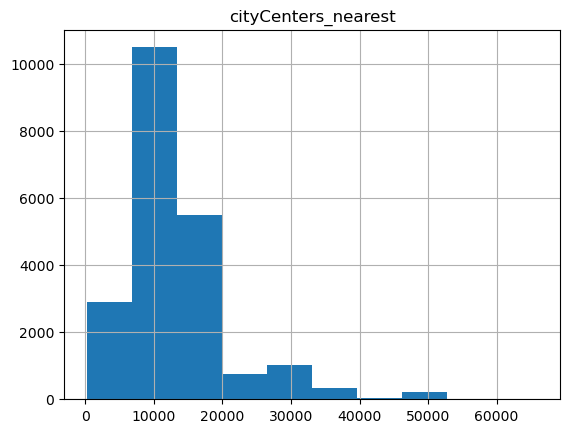

In [32]:
data.hist(column = 'cityCenters_nearest');

Most of the properties on display are located within a 10 km radius of the city center

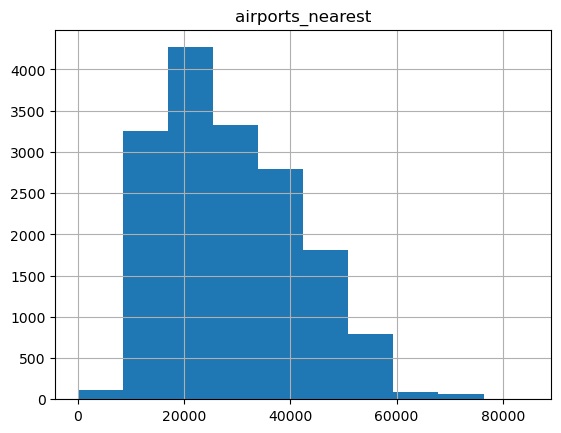

In [33]:
data.hist(column = 'airports_nearest');

There are practically no apartments close to the airport. The bulk is located at a distance of 10 to 30 km from the nearest air harbor

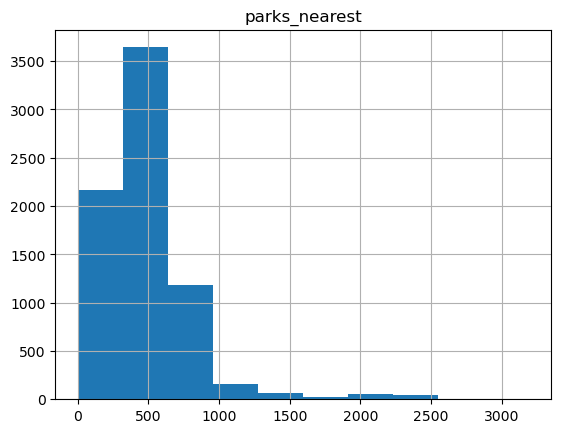

In [34]:
data.hist(column = 'parks_nearest');

St. Petersburg is not the greenest city. However, most often the apartments are located no more than 500 meters from the park

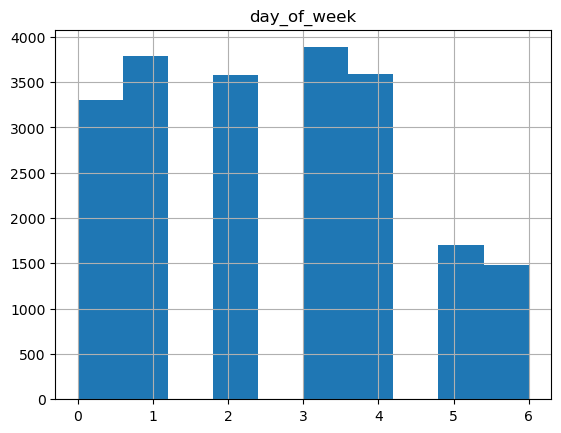

In [35]:
data.hist(column = 'day_of_week');

In the first part of the week, people post ads more often. Monday and Thursday are the most active periods

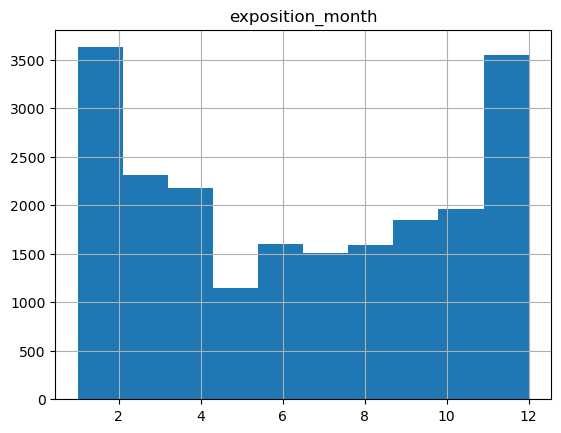

In [36]:
data.hist(column = 'exposition_month');

The end of the year is the time of holidays. But right after and shortly before is the time! With a completely understandable decline in summer

Среднее значение 185.47861385059664
Медианное значение 102.0


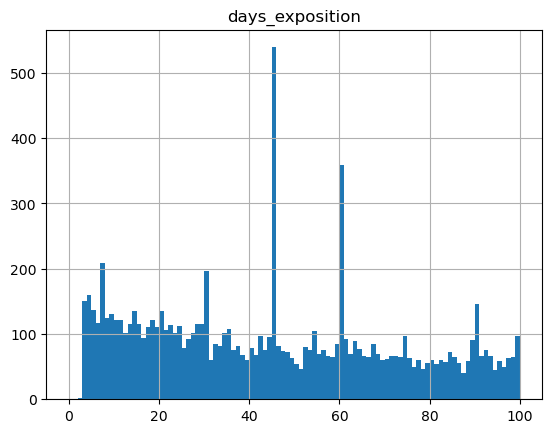

In [37]:
data.hist(column = 'days_exposition', bins = 100, range= (0, 100))
print('Среднее значение', data['days_exposition'].mean())
print('Медианное значение', data['days_exposition'].median())

The average exposure period is 185 days. Sales shorter than 3 months can be considered unusually fast. At the same time, there are also objects with an exposure period from 1 to almost 4 years. Which is without a doubt an extremely long time frame for completing the deal

0.6974488496022737


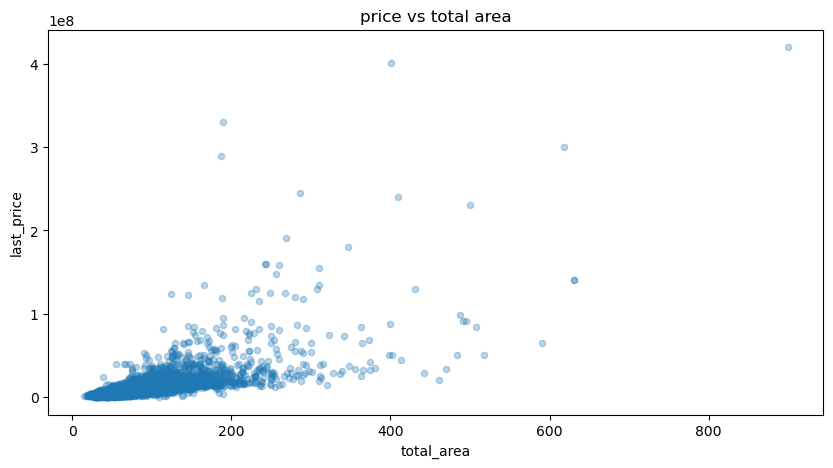

In [38]:
# Let's see if there is a relationship between the price and the total area of housing:

print(data['last_price'].corr(data['total_area']))
data.plot(x='total_area', y='last_price',kind='scatter', alpha=0.3, figsize=(10, 5))
plt.title('price vs total area');

Корреляция безусловно сильная. Чем больше жилье тем оно дороже. При этом существуют аномально дорогие объекты, что тоже 
безусловно нельзя считать ошибкой. Факторов влияющих на стоимость много

0.5877134096702675


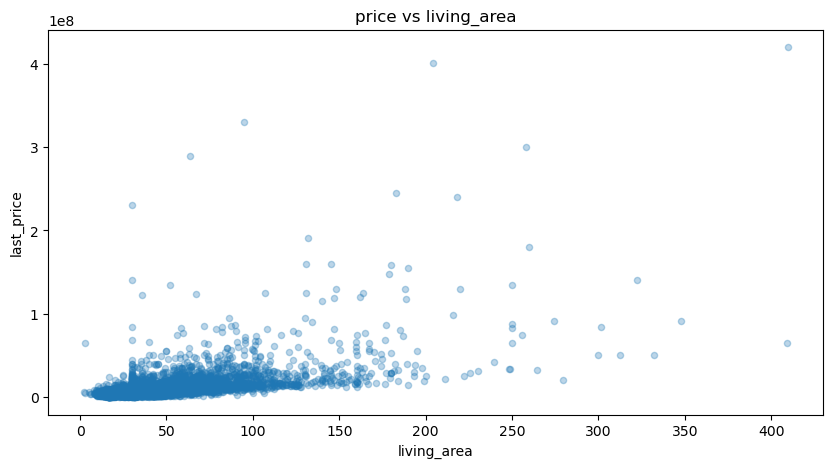

In [39]:
# Let's see if there is a connection between the price and living space of the apartment:

print(data['last_price'].corr(data['living_area']))
data.plot(x='living_area', y='last_price',kind='scatter', alpha=0.3, figsize=(10, 5))
plt.title('price vs living_area');

Все закономерно. Дороже квартира - больше жилая площадь. Хотя корреляция уже не так сильна

0.5204014535281694


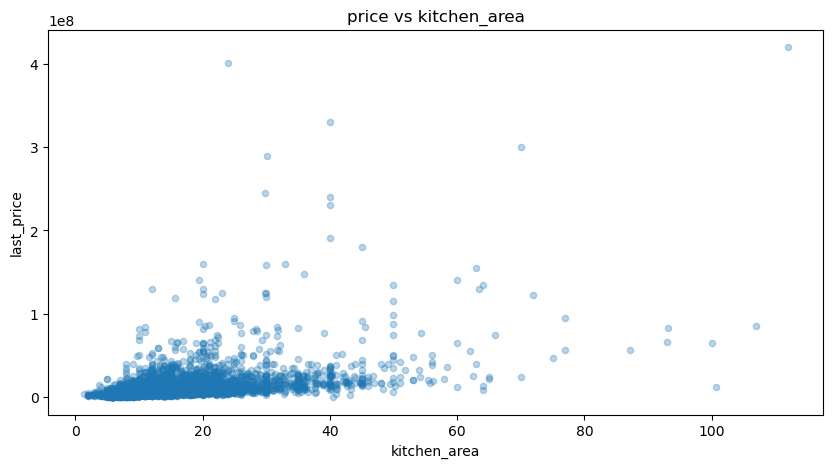

In [40]:
# Let's see if there is a connection between price and kitchen area:

print(data['last_price'].corr(data['kitchen_area']))
data.plot(x='kitchen_area', y='last_price',kind='scatter', alpha=0.3, figsize=(10, 5))
plt.title('price vs kitchen_area');

Again not surprising. If you want Gordon Ramsay's kitchen, pay. At the same time, the size of the kitchen in most cases does not exceed 25 m2

0.39116988097175664


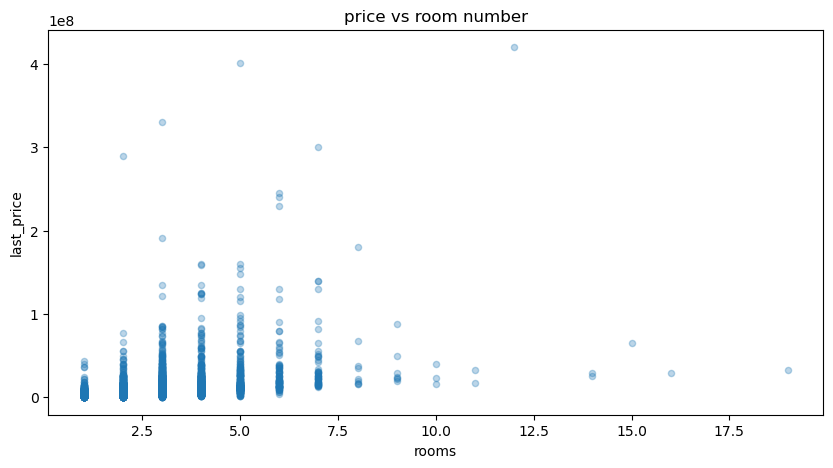

In [41]:
# Let's see if there is a connection between price and number of rooms:

print(data['last_price'].corr(data['rooms']))
data.plot(x='rooms', y='last_price',kind='scatter', alpha=0.3, figsize=(10, 5))
plt.title('price vs room number');

The number of rooms does not affect the cost of the property. Meters are the head of everything

0.03219268156963102


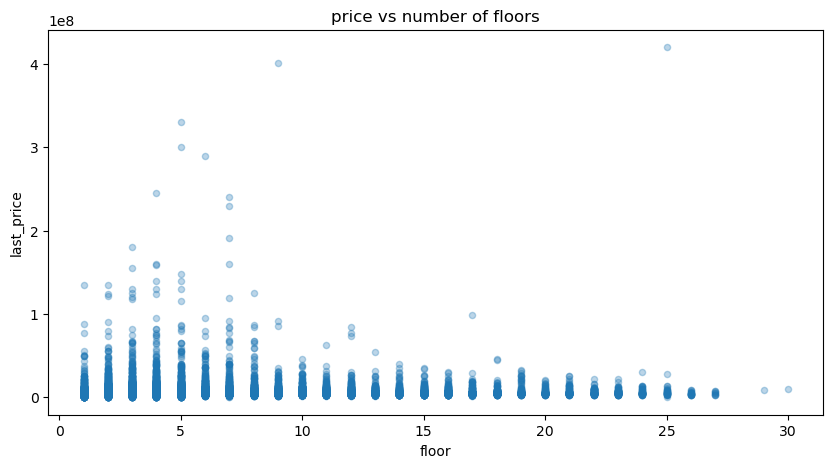

In [55]:
# Let's see if there is a connection between price and number of floors:

print(data['last_price'].corr(data['floor']))
data.plot(x='floor', y='last_price',kind='scatter', alpha=0.3, figsize=(10, 5))
plt.title('price vs number of floors');

There is no connection between the number of floors and the price. Again we can conclude that there are not many tall buildings in St. Petersburg and Leningrad Region

In [43]:
def categorize_floors2 (floor):
    try:
        if floor['floor_type'] == 'первый':
            return '1'
        elif floor['floor_type'] == 'последний':
            return '2'
        else:
            return '3'
    except:
        pass
    
data['floor_type_number'] = data.apply(categorize_floors2, axis = 1)

In [44]:
print(data['floor_type_number'].unique())
data['floor_type_number'] = data['floor_type_number'].astype(int)
print(data.dtypes)

['3' '1' '2']
total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int32
living_area                    float64
floor                            int64
is_apartment                    object
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int32
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
day_of_week                      int64
exposition_month                 int64
exposition_year                  int64
price_m2   

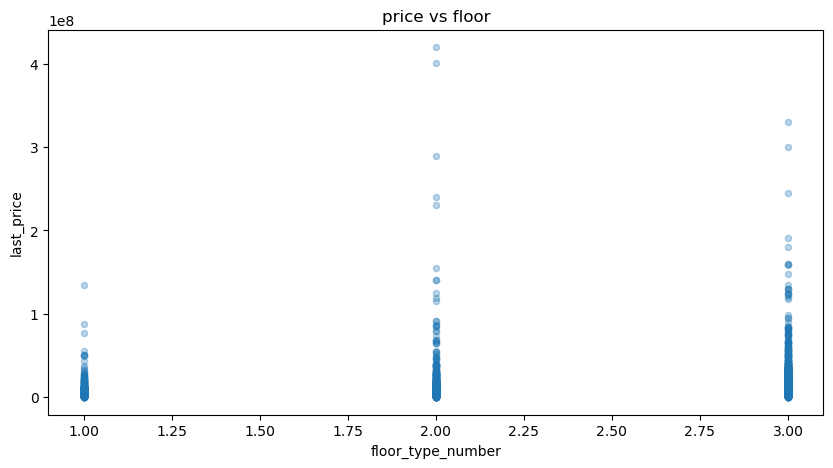

In [54]:
data.plot(x='floor_type_number', y='last_price',kind='scatter', alpha=0.3, figsize=(10, 5))
plt.title('price vs floor');

The cost of apartments on the first floors is the lowest. At the same time, the most expensive, as one would expect, are the apartments on the top floors. Although there are few such offers

-0.005731623948936214


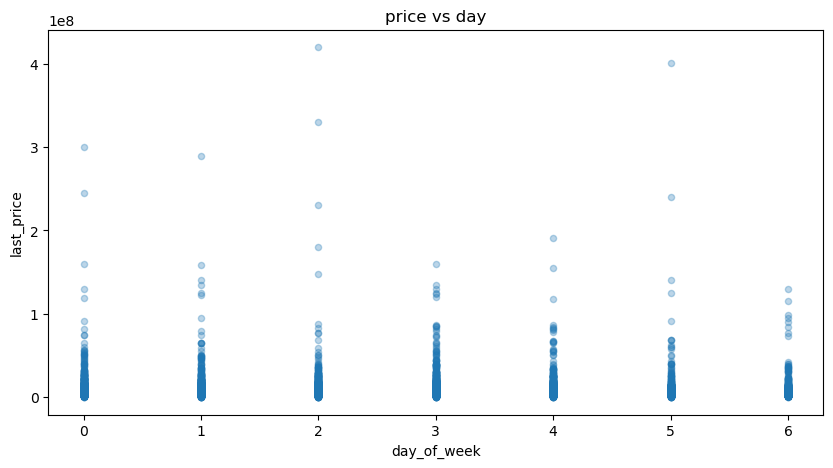

In [46]:
print(data['last_price'].corr(data['day_of_week']))
data.plot(x='day_of_week', y='last_price',kind='scatter', alpha=0.3, figsize=(10, 5))
plt.title('price vs day');

Slightly fewer announcements on Sundays

-0.0007857086795161215


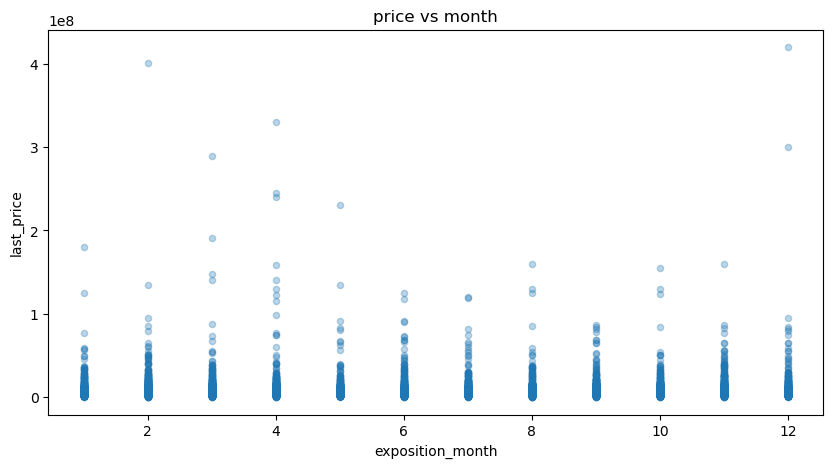

In [47]:
print(data['last_price'].corr(data['exposition_month']))
data.plot(x='exposition_month', y='last_price',kind='scatter', alpha=0.3, figsize=(10, 5))
plt.title('price vs month');

By the end of the year the price decreases slightly. Perhaps this is due to the desire to close the deal before the holidays

-0.04039428493222134


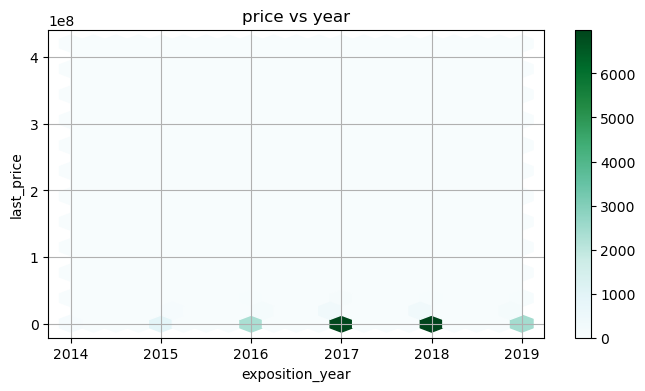

In [48]:
print(data['last_price'].corr(data['exposition_year']))
data.plot(x='exposition_year', y='last_price', kind='hexbin', gridsize=20, figsize=(8, 4), sharex=False, grid=True)
plt.title('price vs year');

Interesting observation. The real estate market, like any other, is influenced by global economic factors. We can clearly see how the number of advertisements grew from 2014 (Crimea, ruble exchange rate....) until the economic crisis of 2018. I am sure that if you look at the 2013 value, it will be greener than all the others. Prices remain the same

In [49]:
# Let's calculate the average price of one square meter in 10 localities with the largest number of advertisements:
print(data.groupby('locality_name').agg({'floor':'count', 'price_m2': 'mean'})\
      .rename(columns ={'floor':'Число объявлений'})\
      .sort_values(by='Число объявлений', ascending=False).head(10))

# Let's see the top 10 most expensive settlements:
print(data.groupby('locality_name').agg({'floor':'count', 'price_m2': 'mean'})\
      .rename(columns ={'floor':'Число объявлений'})\
      .sort_values(by='price_m2', ascending=False).head(10))

# Let's see the top 10 cheapest settlements:
print(data.groupby('locality_name').agg({'floor':'count', 'price_m2': 'mean'})\
      .rename(columns ={'floor':'Число объявлений'})\
      .sort_values(by='price_m2', ascending=True).head(10))

                   Число объявлений       price_m2
locality_name                                     
Санкт-Петербург               14292  114172.628730
поселок Мурино                  449   85265.398465
поселок Шушары                  397   78413.736982
Всеволожск                      357   69029.150099
Пушкин                          338  103247.024342
Колпино                         322   75226.296359
Гатчина                         294   68692.933833
поселок Парголово               289   90691.342386
деревня Кудрово                 231   92147.617400
Выборг                          201   58365.453226
                   Число объявлений       price_m2
locality_name                                     
поселок Репино                    2  127678.571429
Санкт-Петербург               14292  114172.628730
Зеленогорск                      23  113248.785762
деревня Бор                       1  105539.261570
Пушкин                          338  103247.024342
Сестрорецк                     

Here is the popularity rating. You can also judge where they are building more and which direction is being developed more powerfully. At the same time, 'Пушкин' does not lose to St. Petersburg in prices. Same is 'Репино'.

In [50]:
# Let's calculate the average price of each kilometer:

spb = (data.loc[(data['locality_name'] == 'Санкт-Петербург')])

print(spb['last_price'].mean() / spb['city_center_km'].mean())

690779.3944422957


It turns out that the average cost of distance from the city center is almost 700 thousand per km.

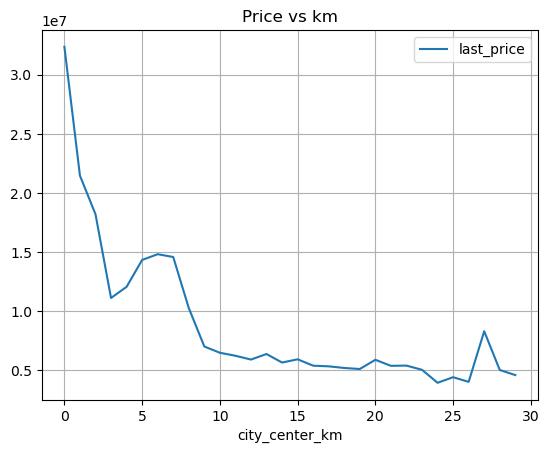

In [52]:
spb.pivot_table(index='city_center_km', values='last_price').plot(grid = True, title = 'Price vs km')
plt.show()

## 5. Conclusion

In this project we managed to do significant work. And identify some patterns.

The average apartment on the real estate market of St. Petersburg and Leningrad Region in the time period from 2014 to 2019 was an object with the following parameters:

Total area: 60.71 Living area: 34.54 Kitchen area: 10.56 Number of rooms: 2.1 Ceiling height: 2.7 Number of floors of the building: 10.59 Distance from the city center: 13.944 Price per square meter: 99264.77

Of course, the cost of an object is primarily influenced by such factors as: locality, area of the apartment, distance from the center. Of course, we do not have all the data that could significantly affect the cost, such as: year of construction, developer, construction technology, availability of communications...

We can conclude that most of the objects are located in residential areas of the city at a considerable distance from the center, which certainly corresponds to the situation in any large city. This is also confirmed by the average number of floors of 10.5 floors. There are practically no such houses in the center of St. Petersburg.

The most expensive settlement was Repino, which is not surprising because this is an analogue of “Rublyovka” for St. Petersburg. Like Zelenogorsk, located a little further, which took third place in the rating. At the same time, in terms of the number of advertisements, Repino is more an anomaly than a statistic.

St. Petersburg, by right of the capital, holds the lead both in the number of advertisements and in the cost of objects. Interestingly, the floor on which the object is located has virtually no effect on its cost. From this we can assume that most of the ads are “secondary” because... the developer always sells the last floors at a higher price than the first.

The cheapest place to live is in the village of Staropolye; the cost per square meter there will be only 10,368.66 rubles.

The number of announcements by year is also extremely interesting. It clearly shows that when the economy is booming, the market is alive. The more deals, the livelier it is.